<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from dataclasses import dataclass
import numpy as np
from scipy.constants import c as c_light
from scipy.integrate import quad
from scipy.special import exp1, expi, gammaincc
from scipy.special import comb
import matplotlib.pyplot as plt

from optic.comm.modulation import modulateGray, demodulateGray, grayMapping, detector
from optic.comm.metrics import fastBERcalc, theoryBER, signal_power, calcEVM
from optic.models.channels import awgn
from optic.models.perturbation import perturbationNLIN
from optic.dsp.equalization import edc
from optic.dsp.core import pnorm, firFilter, pulseShape, delaySignal
from optic.plot import pconst, plotDecisionBoundaries, randomCmap, plotColoredConst, eyediagram
from optic.utils import dB2lin, parameters
from optic.models.tx import simpleWDMTx
from numba import njit, prange
import time

import logging as logg
logg.basicConfig(level=logg.INFO, format='%(message)s', force=True)

try:
    from optic.dsp.coreGPU import checkGPU
    if checkGPU():
        from optic.dsp.coreGPU import firFilter
        from optic.models.modelsGPU import manakovSSF
    else:
        from optic.dsp.core import firFilter
        from optic.models.channels import manakovSSF
except ImportError:
    from optic.dsp.core import firFilter
    from optic.models.channels import manakovSSF

In [2]:
# Run simulation 

# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 16           # order of the modulation format
paramTx.Rs  = 32e9         # symbol rate [baud]
paramTx.SpS = 4            # samples per symbol
paramTx.pulse = 'rrc'      # pulse shaping filter
paramTx.Ntaps = 4096       # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01    # RRC rolloff
paramTx.Pch_dBm = 0        # power per WDM channel [dBm]
paramTx.Nch     = 1        # number of WDM channels
paramTx.Fc      = 193.1e12 # central optical frequency of the WDM spectrum
paramTx.lw      = 0*100e3    # laser linewidth in Hz
paramTx.freqSpac = 37.5e9  # WDM grid spacing
paramTx.Nmodes = 2         # number of signal modes [2 for polarization multiplexed signals]
paramTx.Nbits = int(np.log2(paramTx.M)*1e5) # total number of bits per polarization

# generate WDM signal
sigWDM_Tx, symbTx, paramTx = simpleWDMTx(paramTx)
symbTx = symbTx[:,:,0]

sigWDM_Tx[:,0] = delaySignal(sigWDM_Tx[:,0], -0.25*1/paramTx.Rs, paramTx.Rs*paramTx.SpS)
sigWDM_Tx[:,1] = delaySignal(sigWDM_Tx[:,1], -0.25*1/paramTx.Rs, paramTx.Rs*paramTx.SpS)

  0%|          | 0/1 [00:00<?, ?it/s]

channel 0	 fc : 193.1000 THz
  mode #0	 power: -3.01 dBm
  mode #1	 power: -3.01 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm


Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 54.0565 s
gain: -8 dB
Minimum EVM: 19.12 at amplitude 4.50 and phase 1.49 rad


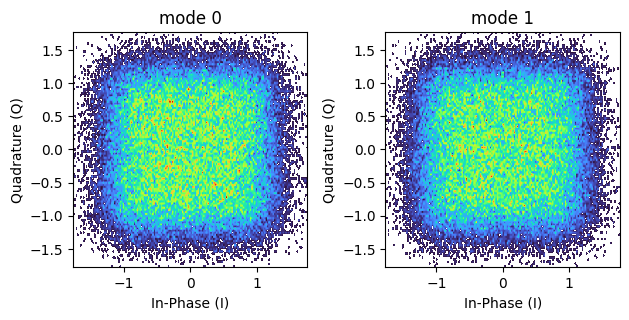

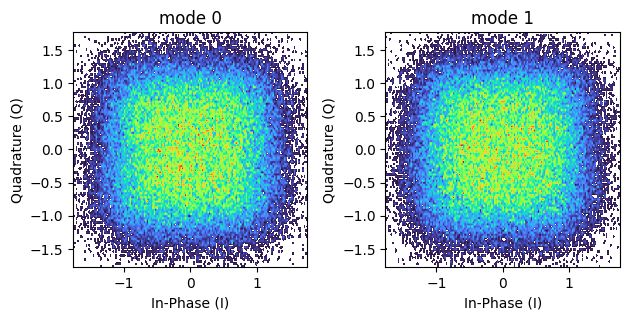

Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 40.1688 s
gain: -7 dB
Minimum EVM: 11.77 at amplitude 4.50 and phase 1.49 rad


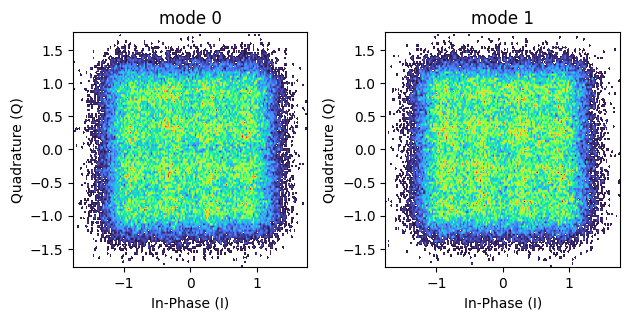

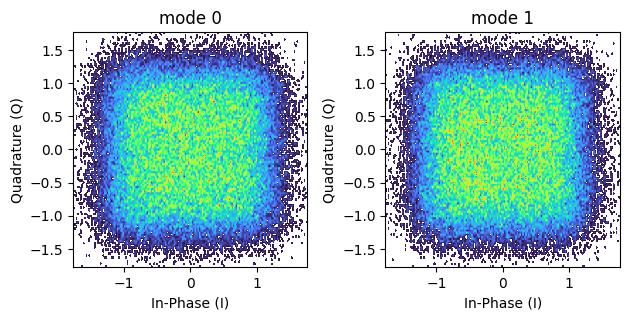

Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 40.8043 s
gain: -6 dB
Minimum EVM: 6.82 at amplitude 4.50 and phase 1.49 rad


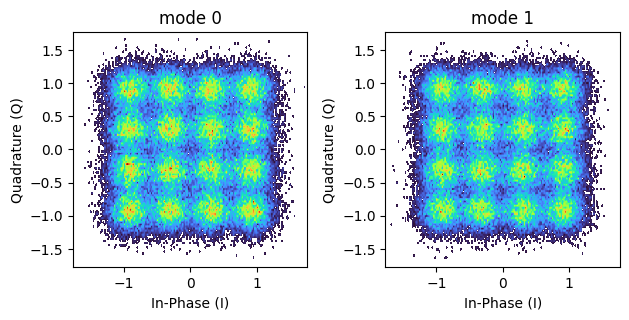

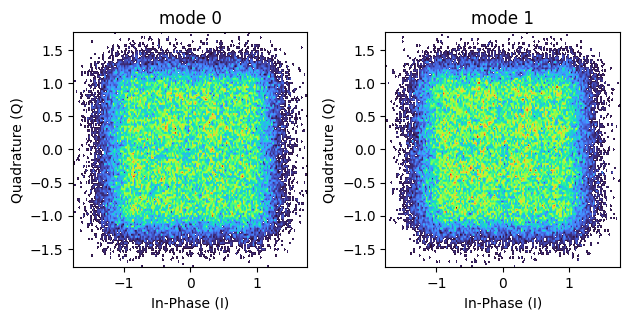

Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 46.4863 s
gain: -5 dB
Minimum EVM: 3.77 at amplitude 4.50 and phase 1.49 rad


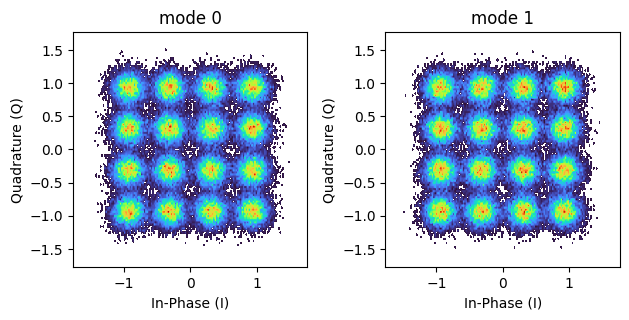

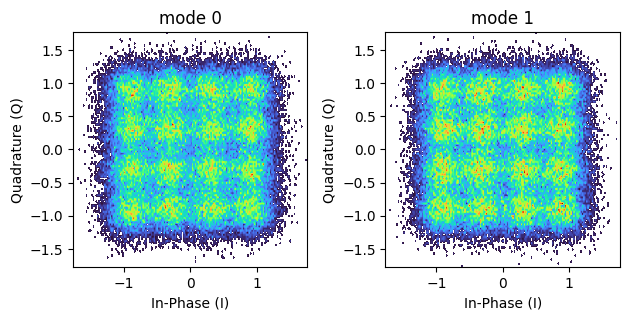

Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 41.2210 s
gain: -4 dB
Minimum EVM: 2.04 at amplitude 4.50 and phase 1.49 rad


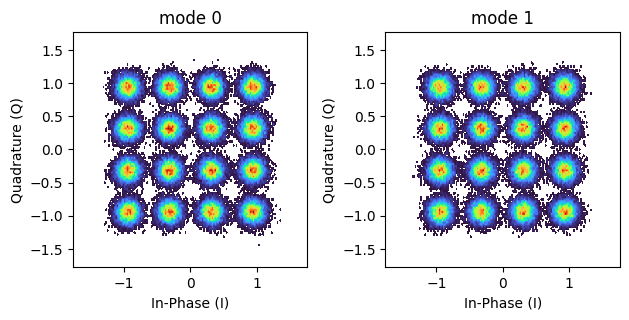

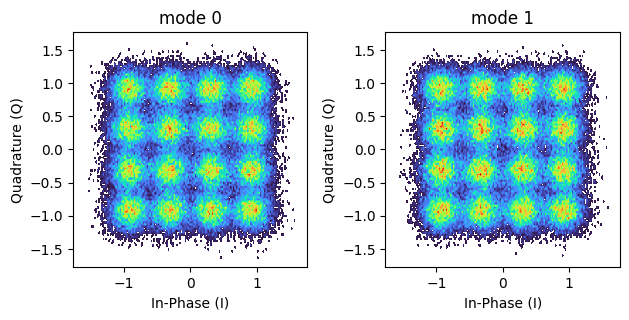

Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 38.6975 s
gain: -3 dB
Minimum EVM: 1.15 at amplitude 4.50 and phase 1.49 rad


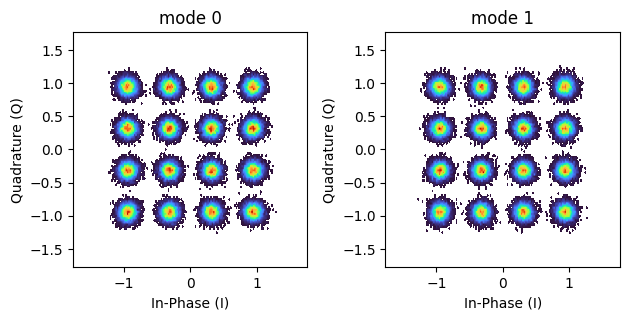

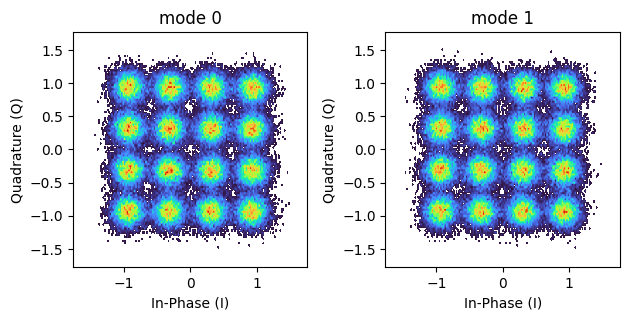

Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 39.7670 s
gain: -2 dB
Minimum EVM: 0.72 at amplitude 4.50 and phase 1.32 rad


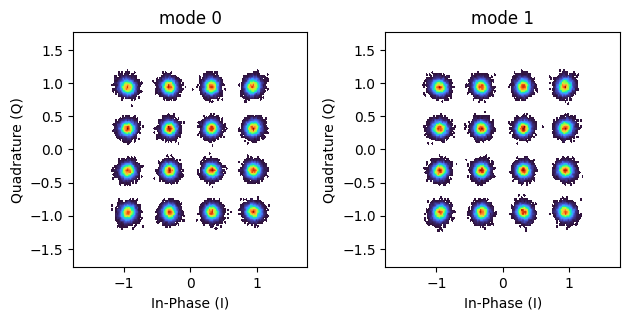

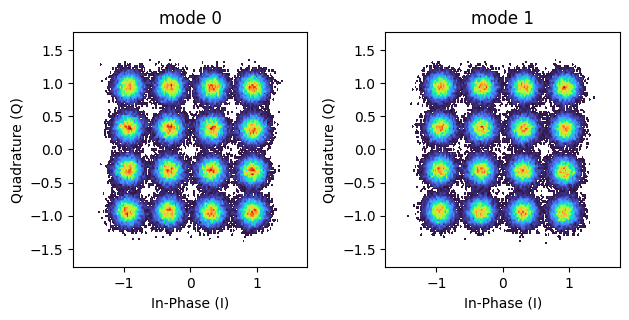

Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 40.1816 s
gain: -1 dB
Minimum EVM: 0.54 at amplitude 4.50 and phase 1.16 rad


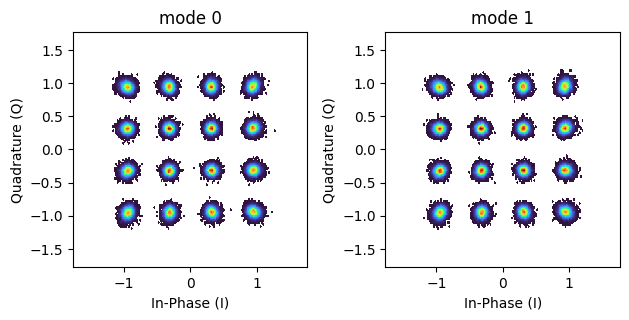

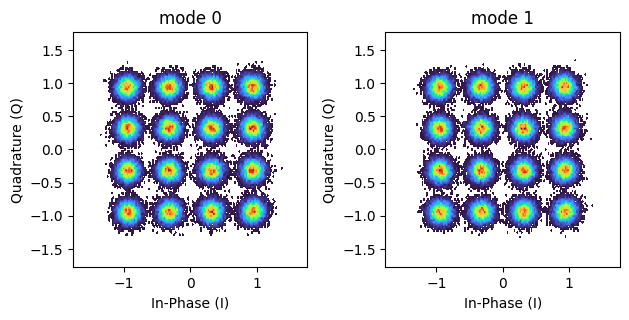

Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 42.0839 s
gain: 0 dB
Minimum EVM: 0.46 at amplitude 3.66 and phase 0.99 rad


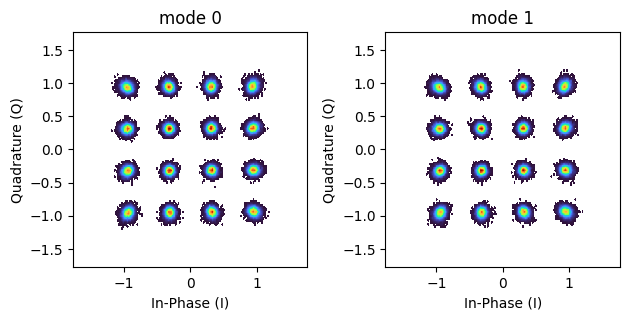

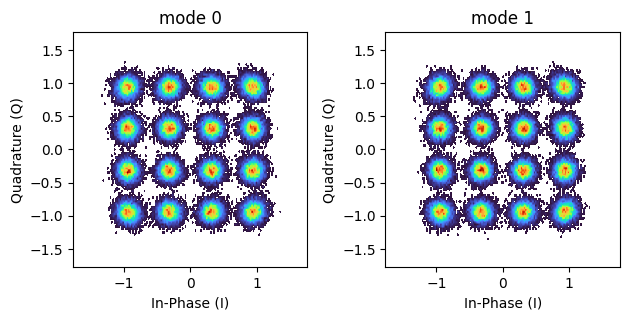

Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 40.6811 s
gain: 1 dB
Minimum EVM: 0.42 at amplitude 3.24 and phase 0.99 rad


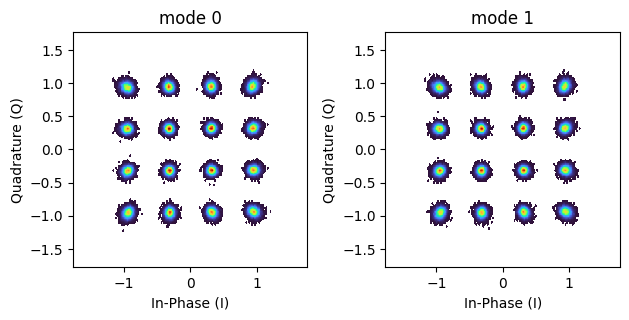

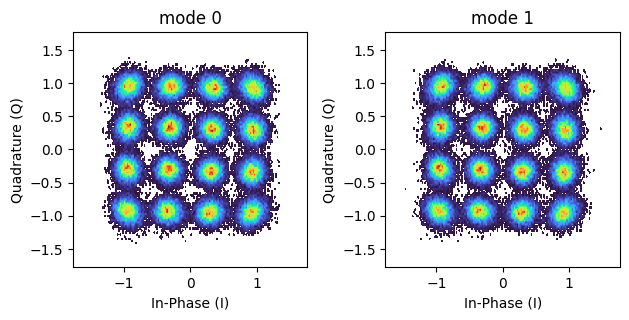

Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 40.7536 s
gain: 2 dB
Minimum EVM: 0.42 at amplitude 3.45 and phase 1.32 rad


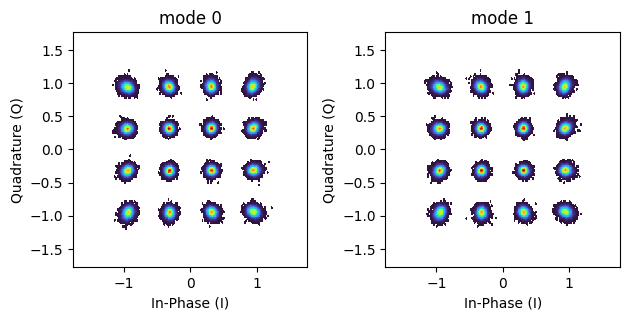

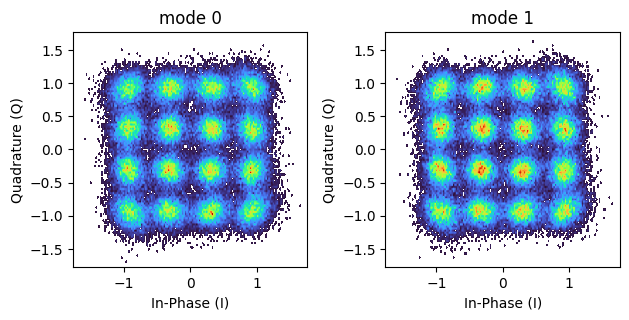

Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 38.9589 s
gain: 3 dB
Minimum EVM: 0.46 at amplitude 4.08 and phase 1.98 rad


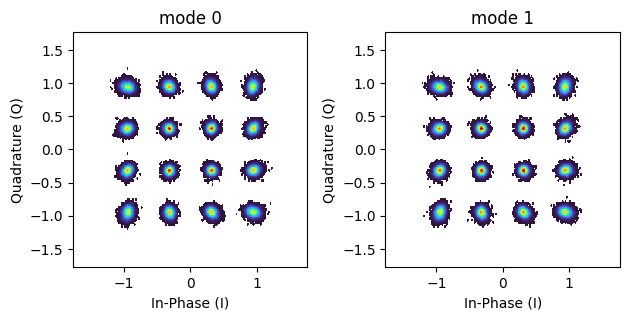

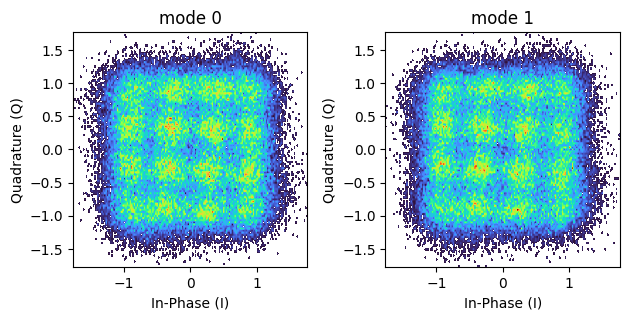

Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 41.0275 s
gain: 4 dB
Minimum EVM: 0.61 at amplitude 4.50 and phase 3.14 rad


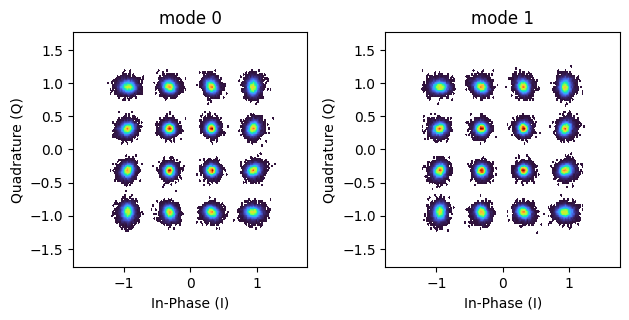

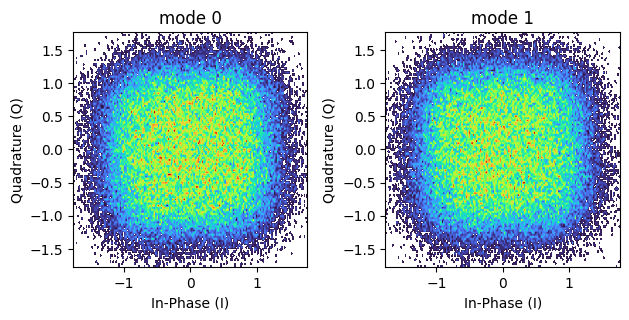

Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 41.0863 s
gain: 5 dB
Minimum EVM: 0.98 at amplitude 4.50 and phase 0.00 rad


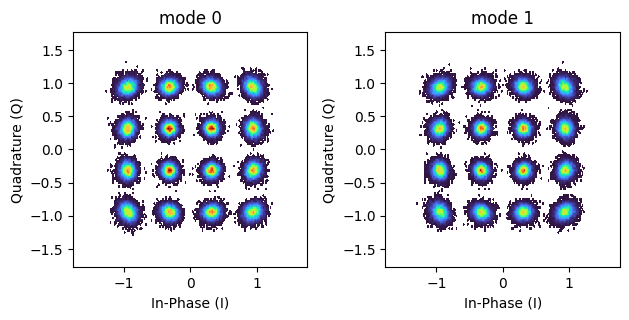

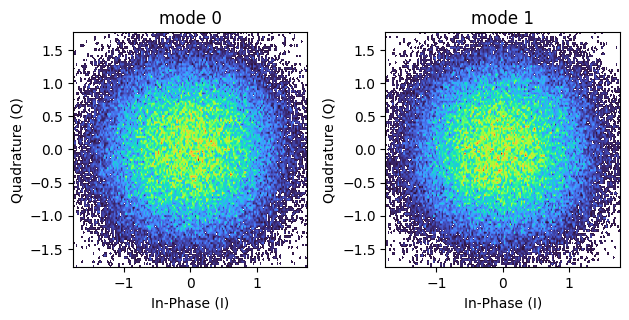

Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 40.9762 s
gain: 6 dB
Minimum EVM: 1.60 at amplitude 4.50 and phase 3.14 rad


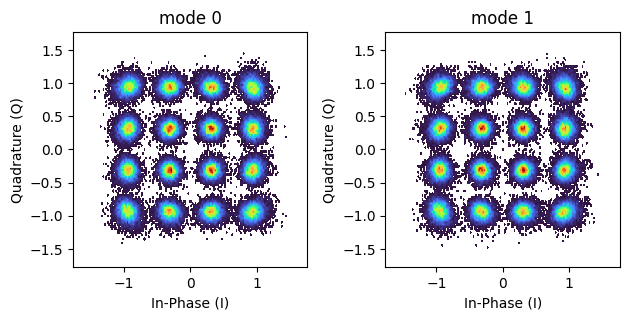

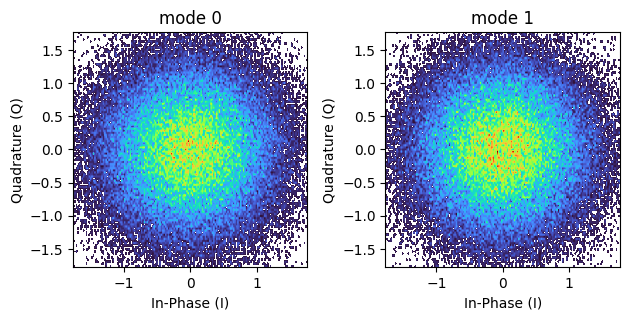

Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 40.8920 s
gain: 7 dB
Minimum EVM: 2.80 at amplitude 4.50 and phase 3.14 rad


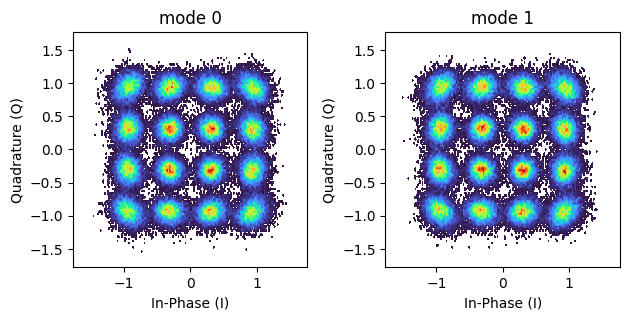

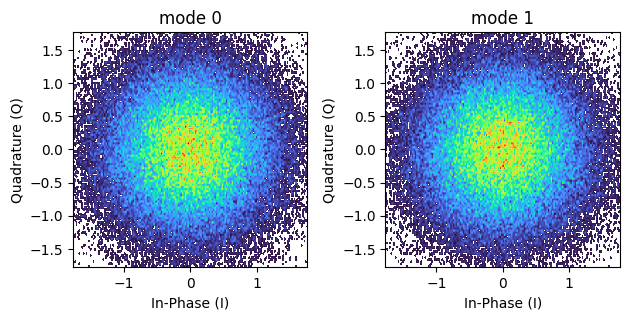

Running Manakov SSF model on GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

Running CD compensation...
CD filter length: 1902 taps, FFT size: 2048
Calculating matrix of perturbation coefficients (standard)...
Matrix of perturbation coefficients calculated. Dimensions: 151 x 151


Number of used coefficients: 3105
Reduction of  86.38 %
Reduced complexity model: 41.9133 s
gain: 8 dB
Minimum EVM: 5.59 at amplitude 4.50 and phase 0.00 rad


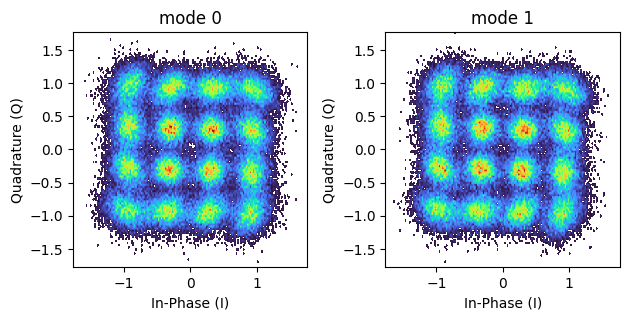

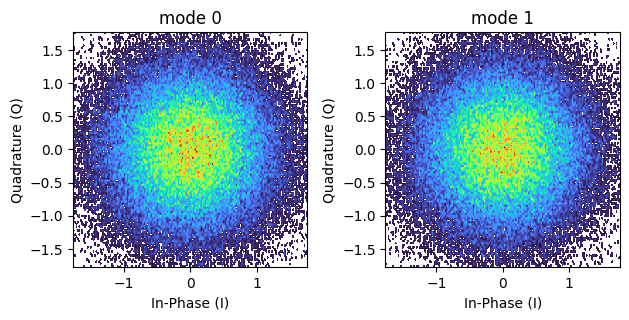

In [3]:
gains = np.arange(-8, 9, 1)
BERedc = np.zeros(len(gains))
BERnlc = np.zeros(len(gains))
SNRedc = np.zeros(len(gains))
SNRnlc = np.zeros(len(gains))

for indPower, gain in enumerate(gains):
    # optical channel parameters
    paramCh = parameters()
    paramCh.Ltotal = 1600     # total link distance [km]
    paramCh.Lspan  = 80      # span length [km]
    paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
    paramCh.D = 17           # fiber dispersion parameter [ps/nm/km]
    paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]
    paramCh.Fc = paramTx.Fc  # central optical frequency of the WDM spectrum
    paramCh.hz = 0.5         # step-size of the split-step Fourier method [km]
    paramCh.maxIter = 5      # maximum number of convergence iterations per step
    paramCh.tol = 1e-5       # error tolerance per step
    paramCh.nlprMethod = True # use adaptive step-size based o maximum nonlinear phase-shift
    paramCh.maxNlinPhaseRot = 2e-2 # maximum nonlinear phase-shift per step
    paramCh.prgsBar = True   # show progress bar
    #paramCh.saveSpanN = [1, 5, 9, 14]
    paramCh.Fs = paramTx.Rs*paramTx.SpS # sampling rate

    # nonlinear signal propagation
    sigWDM = manakovSSF(dB2lin(gain)*sigWDM_Tx, paramCh)

    mf = pulseShape('rrc', paramTx.SpS, paramTx.Ntaps, paramTx.alphaRRC)
    sigRx = firFilter(mf, sigWDM)  # pulse shaping filter

    # dispersion compensation
    paramEDC = parameters()
    paramEDC.L = paramCh.Ltotal
    paramEDC.D = paramCh.D
    paramEDC.Fc = paramTx.Fc
    paramEDC.Rs = paramTx.Rs
    paramEDC.Fs = paramCh.Fs

    sigEDC = edc(sigRx, paramEDC)
    rot = np.mean(sigWDM_Tx[sigEDC!=0]/sigEDC[sigEDC!=0])
    #sigEDC = sigEDC * rot
    sigEDC = np.roll(sigEDC, -1, axis=0)  # roll to remove the first sample

    # Calculate nonlinear impairments from the split-step Fourier method
    # nlinSSF = pnorm(sigEDC[0::paramTx.SpS]) - pnorm(firFilter(mf, sigWDM_Tx)[0::paramTx.SpS])

    #eyediagram((firFilter(mf, sigWDM_Tx))[:, 0].real, sigWDM_Tx.shape[0], paramTx.SpS, ptype='fancy')
    #eyediagram((rot*sigEDC)[:, 0].real, sigEDC.shape[0], paramTx.SpS, ptype='fancy')

    paramNLIN = parameters()
    paramNLIN.mode = 'AM'
    paramNLIN.Pin = paramTx.Pch_dBm + gain
    paramNLIN.coeffTol = -30
    paramNLIN.lspan = paramCh.Lspan
    paramNLIN.length = paramCh.Ltotal
    paramNLIN.alpha = paramCh.alpha
    paramNLIN.D = paramCh.D
    paramNLIN.matrixOrder = 75

    A = np.sqrt(10**(paramNLIN.Pin/10/2)*1e-3)

    #Ein = np.array([symbX, symbY]).T
    Ein = symbTx.copy()

    # start = time.time()
    # nlinA = perturbationNLIN(symbTx, paramNLIN)
    # end = time.time()
    # delay = end - start
    #print(f'Conventional model: {delay:.4f} s')

    paramNLIN.mode = 'AMR'
    start = time.time()
    nlinA = perturbationNLIN(symbTx, paramNLIN)
    end = time.time()
    delay = end - start
    print(f'Reduced complexity model: {delay:.4f} s')

    ntrials = 20
    EVM = np.zeros((ntrials,ntrials))
    phases = np.linspace(0, np.pi, ntrials)
    amps = np.linspace(0.5, 4.5, ntrials)

    for ind1, amp in enumerate(amps): 
        for ind2, phi in enumerate(phases):
            Eout = A*pnorm(sigEDC[0::paramTx.SpS]) - amp*nlinA*np.exp(1j*phi)
            rot = np.mean(Ein / Eout)
            Eout = rot*Eout
            EVM[ind1, ind2] = 100*calcEVM(pnorm(Eout[10000:-10000,:]), 16, 'qam', Ein[10000:-10000,:])[0]

    ind = np.argmin(EVM)
    indx = np.unravel_index(EVM.argmin(), EVM.shape)
    print(f'gain: {gain} dB')
    print(f'Minimum EVM: {EVM[indx[0],indx[1]]:.2f} at amplitude {amps[indx[0]]:.2f} and phase {phases[indx[1]]:.2f} rad')

    Eout = A*pnorm(sigEDC[0::paramTx.SpS]) - amps[indx[0]]*nlinA*np.exp(1j*phases[indx[1]])
    rot = np.mean(Ein / Eout)
    Eout = rot*Eout
    pconst(Eout[10000:-10000,:])

    BER, _, SNR = fastBERcalc(pnorm(Eout[10000:-10000,:]), pnorm(Ein[10000:-10000,:]), paramTx.M, 'qam')
    BERnlc[indPower] = np.mean(BER)
    SNRnlc[indPower] = np.mean(SNR)
    
    symbRx = sigEDC[0::paramTx.SpS]
    Eout = A*pnorm(symbRx) 
    rot = np.mean(Ein[symbRx!=0] / symbRx[symbRx!=0])
    Eout = rot*Eout
    pconst(Eout[10000:-10000,:])

    BER, _, SNR = fastBERcalc(pnorm(Eout[10000:-10000,:]), pnorm(Ein[10000:-10000,:]), paramTx.M, 'qam')
    BERedc[indPower] = np.mean(BER)
    SNRedc[indPower] = np.mean(SNR)
 

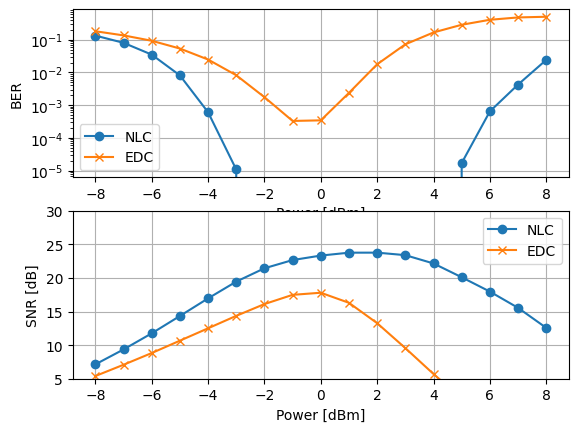

In [4]:
   
plt.figure()
plt.subplot(2,1,1)
plt.plot(gains, BERnlc, marker='o', label='NLC')
plt.plot(gains, BERedc, marker='x', label='EDC')
plt.yscale('log')
plt.xlabel('Power [dBm]')
plt.ylabel('BER')
plt.grid(True)
plt.legend()
plt.subplot(2,1,2)
plt.plot(gains, SNRnlc, marker='o', label='NLC')  
plt.plot(gains, SNRedc, marker='x', label='EDC')
plt.ylim(5, 30)
plt.xlabel('Power [dBm]')
plt.ylabel('SNR [dB]') 
plt.grid(True)
plt.legend()

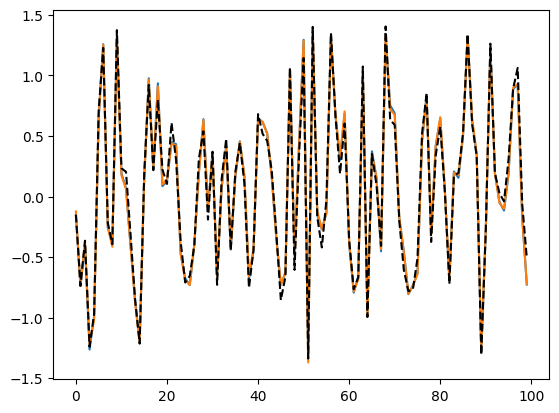

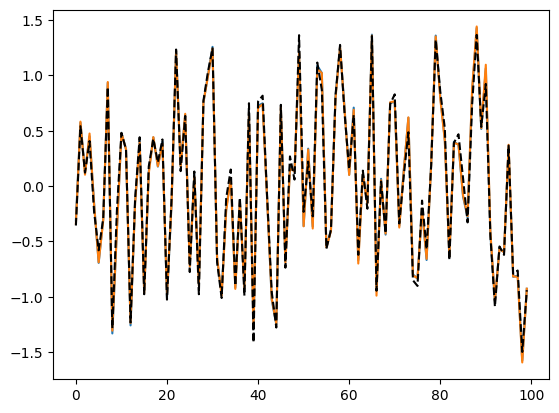

In [113]:
plt.figure()
plt.plot(pnorm(nlinA[200:300,0]).real, '-')
plt.plot(pnorm(nlinB[200:300,0]).real, '-')
plt.plot(pnorm(nlinSSF[200:300,0]).real, 'k--')

plt.figure()
plt.plot(pnorm(nlinA[200:300,0]).imag, '-')
plt.plot(pnorm(nlinB[200:300,0]).imag, '-')
plt.plot(pnorm(nlinSSF[200:300,0]).imag, 'k--')

In [114]:
scaleNLIN = np.mean(nlinSSF/nlinA)

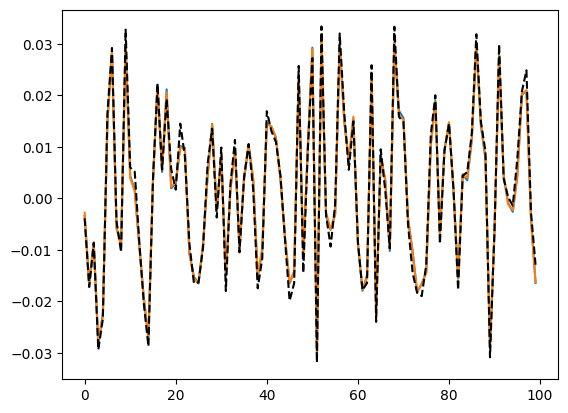

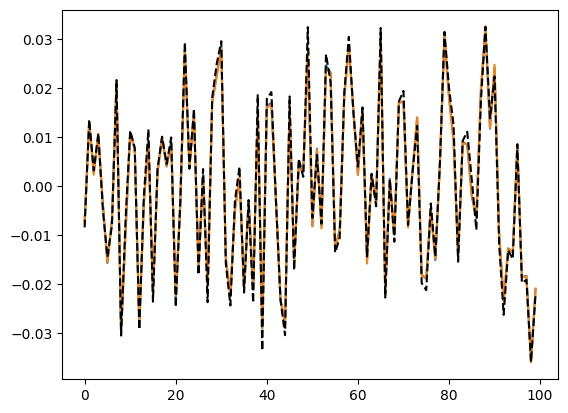

In [115]:
plt.figure()
plt.plot(nlinA[200:300,0].real, '-')
plt.plot(nlinB[200:300,0].real, '-')
plt.plot((nlinSSF[200:300,0]/scaleNLIN).real, 'k--')

plt.figure()
plt.plot(nlinA[200:300,0].imag, '-')
plt.plot(nlinB[200:300,0].imag, '-')
plt.plot((nlinSSF[200:300,0]/scaleNLIN).imag, 'k--')

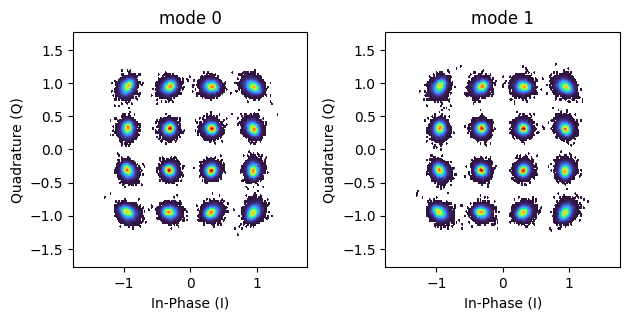

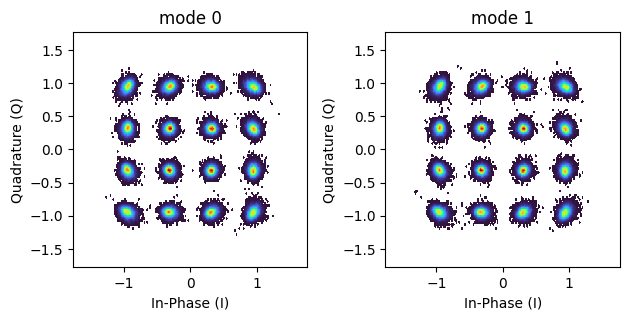

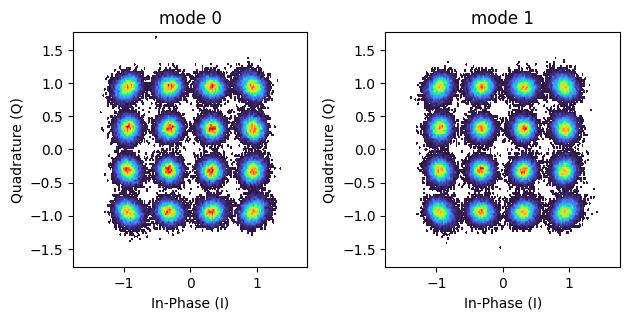

In [116]:
Eout = A*Ein + nlinA
rot = np.mean(Ein / Eout)
Eout = rot*Eout
pconst(Eout)

Eout = A*Ein + nlinB
rot = np.mean(Ein / Eout)
Eout = rot*Eout
pconst(Eout)

Eout = A*pnorm(sigEDC[0::paramTx.SpS])[0:-10000,:]
rot = np.mean(Ein[0:-10000,:]/ Eout)
Eout = rot*Eout
pconst(Eout)

ntrials = 20
EVM = np.zeros((ntrials,ntrials))
phases = np.linspace(0, np.pi, ntrials)
amps = np.linspace(0.5, 2.5, ntrials)

for ind1, amp in enumerate(amps): 
    for ind2, phi in enumerate(phases):
        Eout = A*pnorm(sigEDC[0::paramTx.SpS]) - amp*nlinA*np.exp(1j*phi)
        rot = np.mean(Ein / Eout)
        Eout = rot*Eout
        EVM[ind1, ind2] = 100*calcEVM(pnorm(Eout[10000:-10000,:]), 16, 'qam', Ein[10000:-10000,:])[0]

Minimum EVM: 0.39 at amplitude 2.18 and phase 0.66 rad


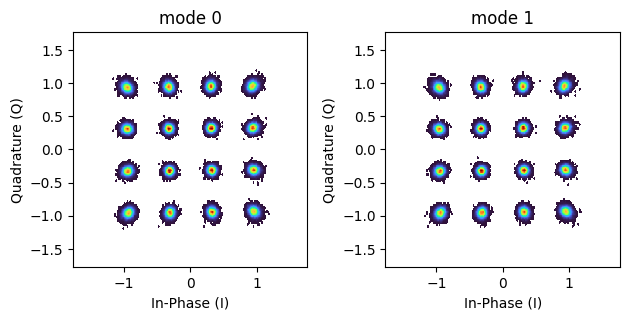

In [117]:

ind = np.argmin(EVM)
indx = np.unravel_index(EVM.argmin(), EVM.shape)
print(f'Minimum EVM: {EVM[indx[0],indx[1]]:.2f} at amplitude {amps[indx[0]]:.2f} and phase {phases[indx[1]]:.2f} rad')

Eout = A*pnorm(sigEDC[0::paramTx.SpS]) - amps[indx[0]]*nlinA*np.exp(1j*phases[indx[1]])
rot = np.mean(Ein / Eout)
Eout = rot*Eout
pconst(Eout[10000:-10000,:]);